# Single model evaluations in Process
When understanding or investigating an individual model within Process, it can be useful to run the model in isolation and plot some responses. This is done here to investigate the effect of tungsten impurity concentration on radiated power and power incident on the divertor.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import process
from process.main import SingleRun

## Set up
First, inspect a variable to check its uninitialised value:

In [2]:
print(
    f"p_plasma_separatrix_mw = {process.fortran.physics_variables.p_plasma_separatrix_mw}"
)

p_plasma_separatrix_mw = 0.0


In order to initialise all variables in Process with their values at a given point (design parameter vector), run a once-through input file (one with no optimisation) to initialise values in all models. The "large tokamak" regression test solution is used here.

In [3]:
single_run = SingleRun("data/large_tokamak_once_through_IN.DAT")
single_run.run()

The IN.DAT file does not contain any obsolete variables.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
 Version : 3.1.0
 Git Tag : v3.1.0-338-g074d5b12e
 Git Branch : 3437-individual-model-running-examples
 Date : 03/04/2025 UTC
 Time : 09:00
 User : jon
 Computer : jon-Precision-3560
 Directory : /home/jon/code/process/examples
 Input : /home/jon/code/process/examples/data/large_tokamak_once_through_IN.DAT
 Run title : generic large tokamak
 Run type : Reactor concept design: Pulsed tokamak model model, (c) UK Atomic Energy Authority
 
 **************************************************

/home/jon/code/process/process/init.py:47: UserWarning: tmargmin_cs and tmargmin should not both be specified in IN.DAT tmargmin_cs has been ignored
  check_process(inputs)
process.pfcoil - WARNING - Ratio of central solenoid overall current density at beginning of flat-top / end of flat-top > 1 (|f_j_cs_start_end_flat_top| > 1)
/home/jon/code/process/process/costs.py:2799: RuntimeWarning: invalid value encountered in sqrt
  annoam = cost_variables.ucoam[cost_variables.lsa - 1] * np.sqrt(
/home/jon/code/process/process/costs.py:2868: RuntimeWarning: invalid value encountered in sqrt
  annwst = cost_variables.ucwst[cost_variables.lsa - 1] * np.sqrt(
process.power - ERROR - ERROR Negative stored energy in poloidal field


 Warning in routine OCMMNT :

*Cryostat roof allowance includes uppermost PF coil and outer thermal shield.
*Cryostat floor allowance includes lowermost PF coil, outer thermal shield and gravity support.
This is longer than 110 columns.
 Warning in routine OCMMNT :

*Cryostat roof allowance includes uppermost PF coil and outer thermal shield.
*Cryostat floor allowance includes lowermost PF coil, outer thermal shield and gravity support.
This is longer than 110 columns.
 Warning in routine OCMMNT :

*Cryostat roof allowance includes uppermost PF coil and outer thermal shield.
*Cryostat floor allowance includes lowermost PF coil, outer thermal shield and gravity support.
This is longer than 110 columns.
 Warning in routine OCMMNT :

*Cryostat roof allowance includes uppermost PF coil and outer thermal shield.
*Cryostat floor allowance includes lowermost PF coil, outer thermal shield and gravity support.
This is longer than 110 columns.
 Warning in routine OCMMNT :

*Cryostat roof allowan

In [4]:
# Kernel can crash when running physics without correctly initialised values
# Doesn't crash after running a once-through
# Print initial values of interest
def print_values():
    print(
        f"W frac = {process.fortran.impurity_radiation_module.impurity_arr_frac[13]:.3e}"
    )
    print(f"p_plasma_rad_mw = {process.fortran.physics_variables.p_plasma_rad_mw:.3e}")
    print(
        f"p_plasma_separatrix_mw = {process.fortran.physics_variables.p_plasma_separatrix_mw:.3e}"
    )


print_values()

W frac = 5.000e-06
p_plasma_rad_mw = 2.191e+02
p_plasma_separatrix_mw = 1.699e+02


Now try increasing the tungsten impurity fraction to see if there's a change in the divertor power.

In [5]:
process.fortran.impurity_radiation_module.impurity_arr_frac[13] = 5.0e-5
single_run.models.physics.physics()
print_values()

W frac = 5.000e-05
p_plasma_rad_mw = 2.785e+02
p_plasma_separatrix_mw = 1.095e+02


With a higher W impurity fraction, the radiated power has increased and the power incident on the divertor has decreased.

## Parameter study of W impurity
Now investigate effect of varying W impurity on impurity radiation power, divertor power and constraint 15 (L-H threshold constraint).

In [6]:
def run_impurities(w_imp_fracs):
    """Calculate responses to W impurities."""
    n = w_imp_fracs.shape[0]
    p_plasma_rad_mw = np.empty(n)
    p_plasma_separatrix_mw = np.empty(n)
    p_l_h_threshold_mw = np.empty(n)
    con15 = np.empty(n)

    # Loop over W impurity values, evaluate model and store responses at each point
    for i, imp_frac in enumerate(w_imp_fracs):
        # Set W impurity fraction, then run physics model
        process.fortran.impurity_radiation_module.impurity_arr_frac[13] = imp_frac
        single_run.models.physics.physics()

        # Evaluate constraint equation 15 (L-H threshold constraint)
        con15_value, _, _, _, _ = process.fortran.constraints.constraint_eqn_015()

        # Need to copy values
        p_plasma_rad_mw[i] = process.fortran.physics_variables.p_plasma_rad_mw.item()
        p_plasma_separatrix_mw[i] = (
            process.fortran.physics_variables.p_plasma_separatrix_mw.item()
        )
        p_l_h_threshold_mw[i] = (
            process.fortran.physics_variables.p_l_h_threshold_mw.item()
        )
        # Need to flip sign of constraint so negative means violated
        con15[i] = -con15_value

    return p_plasma_rad_mw, p_plasma_separatrix_mw, p_l_h_threshold_mw, con15

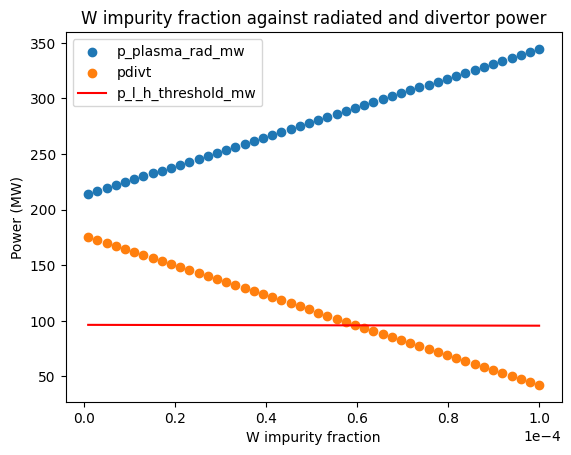

In [7]:
%matplotlib inline
# Run W impurity parameter study
w_imp_fracs = np.linspace(1.0e-6, 1.0e-4, 50)
p_plasma_rad_mw, p_plasma_separatrix_mw, p_l_h_threshold_mw, con15 = run_impurities(
    w_imp_fracs
)

fig, ax = plt.subplots()
ax.scatter(w_imp_fracs, p_plasma_rad_mw, label="p_plasma_rad_mw")
ax.scatter(w_imp_fracs, p_plasma_separatrix_mw, label="p_plasma_separatrix_mw")
ax.plot(w_imp_fracs, p_l_h_threshold_mw, "r", label="p_l_h_threshold_mw")
ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
ax.set_title("W impurity fraction against radiated and divertor power")
ax.set_xlabel("W impurity fraction")
ax.set_ylabel("Power (MW)")
ax.legend()

How does the L-H threshold constraint vary?

Text(0.0, -0.15, 'Violated')

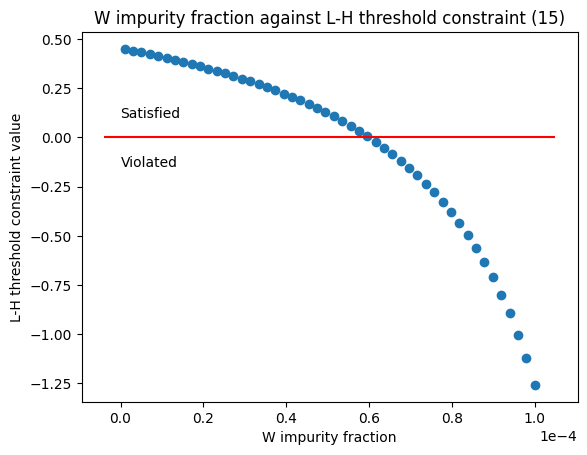

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(w_imp_fracs, con15, label="con15")
ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
ax.set_title("W impurity fraction against L-H threshold constraint (15)")
ax.set_xlabel("W impurity fraction")
ax.set_ylabel("L-H threshold constraint value")
ax.hlines(0.0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors="r")
ax.annotate("Satisfied", (0.0, 0.1))
ax.annotate("Violated", (0.0, -0.15))

The constraint becomes violated for W fraction values $> 6\times10^{-5}$.

This can easily be modified to investigate behaviour of any model in Process in isolation, without running other models or optimising.